# Exercise. Entretien technique - 11/04/2023

Afin de préparer votre entretien, nous vous demandons de préparer un exercice qui
permettra d’évaluer vos compétences en analyse et restitution de données.
Vous avez reçu ci-joint un jeu de données représentant les résultats par commune
française d’un vote à un référendum fictif ayant eu lieu en 2013.
Nous vous proposons de répondre à la question suivante :

« Que pouvez-vous nous montrer d’instructif à propos de ces données ? »

Vous pourrez par exemple vous aider de données publiques complémentaires :
- http://tiny.cc/a924gy
- http://tiny.cc/ia43gy
- http://tiny.cc/mc43gy

Nous vous invitons à travailler préférentiellement avec Python ou R.
Lors de l’entretien, nous vous demanderons de présenter vos résultats et votre démarche
pour les obtenir (code source, outils utilisés, etc).
Pensez à amener un ordinateur ! Si vous ne pouvez en amener un, prenez contact avec
nous afin que nous vous en prêtions un pendant l’entretien.
Au cours de l’entretien, vous serez potentiellement amenés à fournir des analyses
complémentaires en temps réel.

# Exploration des données 

### Lecture du fichier .csv et interprétation des données brutes

Je commence par importer les modules qui me seront utiles : 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import geopandas as gpd
%matplotlib inline

J'identifie le répertoire de travail actuel et le sauvegarde dans une variable:

In [2]:
home_cwd = os.getcwd()
home_cwd

'C:\\Users\\apeco\\OneDrive\\Escritorio\\Vida\\Job offers\\Saint Gobain - Paris'

J'introduis les données dans un objet du type dataframe :

In [3]:
ref_df = pd.read_csv("Referendum.csv", sep=';') # j'ai ouvert le fichier sur le bloc des notes pour le sep ";"
ref_df.head()

Code du département Libellé du département  Code de la commune  \
0                   1                    AIN                   1   
1                   1                    AIN                   2   
2                   1                    AIN                   4   
3                   1                    AIN                   5   
4                   1                    AIN                   6   

     Libellé de la commune  Inscrits  Abstentions  Blancs et nuls  Choix A  \
0  L'Abergement-Clémenciat       592           84               9      154   
1    L'Abergement-de-Varey       215           36               5       66   
2        Ambérieu-en-Bugey      8205         1698             126     2717   
3      Ambérieux-en-Dombes      1152          170              18      280   
4                  Ambléon       105           17               1       35   

   Choix B  
0      345  
1      108  
2     3664  
3      684  
4       52

In [4]:
ref_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36791 entries, 0 to 36790
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Code du département     36791 non-null  object
 1   Libellé du département  36791 non-null  object
 2   Code de la commune      36791 non-null  int64 
 3   Libellé de la commune   36791 non-null  object
 4   Inscrits                36791 non-null  int64 
 5   Abstentions             36791 non-null  int64 
 6   Blancs et nuls          36791 non-null  int64 
 7   Choix A                 36791 non-null  int64 
 8   Choix B                 36791 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 2.5+ MB


Le fichier .csv contient les résultats d'un référendum par commune. Pour chacune des 36791 communes, il contient l'information suivante :
________________________________
- Des informations sur la commune :
    - Code du département
    - Libellé du département
    - Code de la commune 
    - Libellé de la commune
_________________________
    
- Des informations sur la population électorale et les résultats du référendum :
    - Nombre d'inscrits
    - Absentions
    - Votes blancs et nuls
    - Votes pour le choix A
    - Votes pour le choix B

### Feature engineering

Des variables supplémentaires pourraient m'aider à mieux interpréter les résultats du référendum. 

- Taux d'abstenstion (sur 1)
- Votes totaux - utiles pour le calcul des taux suivants
- Taux de votes blancs et nuls (sur 1)
- Taux de votes pour le choix A (sur 1)
- Taux de votes pour le choix B (sur 1)

In [5]:
ref_df['t_abs'] = ref_df['Abstentions']/ref_df['Inscrits']
ref_df['Votes'] = ref_df['Inscrits'] - ref_df['Abstentions']
ref_df['t_null'] = ref_df['Blancs et nuls']/ref_df['Votes']

ref_df['t_A'] = ref_df['Choix A']/ref_df['Votes']

# le taux de votes du choix B n'est pas nécessaire, mais on le fait pour être sûrs que la somme donne 1 :
ref_df['t_B'] = ref_df['Choix B']/ref_df['Votes']

On s'assure que la somme des taux donne 1 et qu'il n'y a pas une erreur dans les données - jusqu'à une précision de cinq chiffres decimaux.

In [6]:
sum(np.round((ref_df['t_A'] + ref_df['t_B'] + ref_df['t_null']), 5) != 1.0000)

0

Informations sur le référendum :

In [7]:
votes_total = ref_df['Inscrits'].sum() - ref_df['Abstentions'].sum()

t_votes_A = ref_df['Choix A'].sum()/votes_total
t_votes_B = ref_df['Choix B'].sum()/votes_total
t_null_total = ref_df['Blancs et nuls'].sum()/votes_total
t_abstention = ref_df['Abstentions'].sum()/ref_df['Inscrits'].sum()

In [8]:
print(f"Votes A: {round(t_votes_A*100, 2)} %")
print(f"Votes B: {round(t_votes_B*100, 2)} %")

print(f"Votes nuls et blancs: {round(t_null_total*100, 2)} %")
print(f"Abstention totale: {round(t_abstention*100, 2)} %")

Votes A: 42.91 %
Votes B: 55.17 %
Votes nuls et blancs: 1.92 %
Abstention totale: 20.52 %


### Incorporation des données publiques fournies :

J'ai sauvegardé les données publiques dans le répertoire "extra-data". On accède à elles :

In [9]:
os.chdir(Path(home_cwd, 'extra_data'))
os.listdir()

['base-cc-evol-struct-pop-2013.xls',
 'filo-revenu-pauvrete-menage-2013.xls',
 'pop-16ans-dipl6819_v2.xls']

1. Évolution et structure de la population en 2013 :

In [10]:
df_1 = pd.read_excel('base-cc-evol-struct-pop-2013.xls', skiprows=4).drop(0, axis=0) # la première file n'est pas utile
df_1.head()

Code géographique Région Région 2016 Département     Libellé géographique  \
1             01001     82          84          01  L'Abergement-Clémenciat   
2             01002     82          84          01    L'Abergement-de-Varey   
3             01004     82          84          01        Ambérieu-en-Bugey   
4             01005     82          84          01      Ambérieux-en-Dombes   
5             01006     82          84          01                  Ambléon   

  Population en 2013 (princ) Pop 0-14 ans en 2013 (princ)  \
1                        767                   176.016667   
2                        236                    44.376068   
3                      14359                  3049.353947   
4                     1635.0                   337.300803   
5                        108                    11.571429   

  Pop 15-29 ans en 2013 (princ) Pop 30-44 ans en 2013 (princ)  \
1                     95.383333                    163.233333   
2                     35.299145                     60.512821   
3                   2857.742493                    2771.06648   
4                    252.470661                    324.172329   
5                     17.357143                     23.142857   

  Pop 45-59 ans en 2013 (princ)  ... Pop 25-54 ans Autres en 2013 (compl)  \
1                    149.466667  ...                                    0   
2                     38.324786  ...                             8.068376   
3                   2660.372622  ...                           576.509717   
4                    377.696109  ...                            30.296479   
5                     26.035714  ...                             7.714286   

  Pop 55 ans ou plus en 2013 (compl)  \
1                         220.266667   
2                          72.615385   
3                        3866.924234   
4                         449.397776   
5                          50.142857   

  Pop 55 ans ou plus Agriculteurs exploitants en 2013 (compl)  \
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            
5                                                  0            

  Pop 55 ans ou plus Artisans, Comm., Chefs entr. en 2013 (compl)  \
1                                                  0                
2                                                  0                
3                                          52.911143                
4                                           5.049413                
5                                                  0                

  Pop 55 ans ou plus Cadres, Prof. intel. sup. en 2013 (compl)  \
1                                          15.733333             
2                                                  0             
3                                          87.563074             
4                                          25.247066             
5                                                  0             

  Pop 55 ans ou plus Prof. intermédiaires en 2013 (compl)  \
1                                           3.933333        
2                                                  0        
3                                         183.633141        
4                                          20.197653        
5                                           7.714286        

  Pop 55 ans ou plus Employés en 2013 (compl)  \
1                                   19.666667   
2                                           0   
3                                  213.080703   
4                                   25.247066   
5                                    7.714286   

  Pop 55 ans ou plus Ouvriers en 2013 (compl)  \
1                                        11.8   
2                                    8.068376   
3                                  197.206645   
4   

Les paramètres sont :

In [11]:
list(df_1.columns)

['Code géographique',
 'Région',
 'Région 2016',
 'Département',
 'Libellé géographique',
 'Population en 2013 (princ)',
 'Pop 0-14 ans en 2013 (princ)',
 'Pop 15-29 ans en 2013 (princ)',
 'Pop 30-44 ans en 2013 (princ)',
 'Pop 45-59 ans en 2013 (princ)',
 'Pop 60-74 ans en 2013 (princ)',
 'Pop 75-89 ans en 2013 (princ)',
 'Pop 90 ans ou plus en 2013 (princ)',
 'Pop Hommes en 2013 (princ)',
 'Pop Hommes 0-14 ans en 2013 (princ)',
 'Pop Hommes 15-29 ans en 2013 (princ)',
 'Pop Hommes 30-44 ans en 2013 (princ)',
 'Pop Hommes 45-59 ans en 2013 (princ)',
 'Pop Hommes 60-74 ans en 2013 (princ)',
 'Pop Hommes 75-89 ans en 2013 (princ)',
 'Pop Hommes 90 ans ou plus en 2013 (princ)',
 'Pop Hommes 0-19 ans en 2013  (princ)',
 'Pop Hommes 20-64 ans en 2013 (princ)',
 'Pop Hommes 65 ans ou plus en 2013 (princ)',
 'Pop Femmes en 2013 (princ)',
 'Pop Femmes 0-14 ans en 2013 (princ)',
 'Pop Femmes 15-29 ans en 2013 (princ)',
 'Pop Femmes 30-44 ans en 2013 (princ)',
 'Pop Femmes 45-59 ans en 2013 (pr

Je fais une sélection parmi quelques variables. Cela n'est pas une étude exhaustive, et dans un problème réel, des experts en analyse des résultats électoraux pourraient m'aider à identifier d'autres variables.

Parmi toutes ces données, on garde seulement les suivantes :
- Taux d'hommes (sur 1)
- Moyenne d'âge de la population
- Taux de personnes ayant un emploi (sur 1)
- Taux de cadres et professions intélectuelles supérieures parmi tous les employés (sur 1)
- Taux d'ouvriers parmi les employés (sur 1)

In [12]:
df_1['t_hommes'] = df_1['Pop Hommes en 2013 (princ)']/(df_1['Pop Femmes en 2013 (princ)'] + df_1['Pop Hommes en 2013 (princ)'] + 1e-10) # to avoid division error

# Estimation de l'age moyen :
df_1['age_moyen'] = (df_1['Pop 0-14 ans en 2013 (princ)']*14 + df_1['Pop 15-29 ans en 2013 (princ)']*(29+15) +
                     df_1['Pop 30-44 ans en 2013 (princ)']*(44+30) + df_1['Pop 45-59 ans en 2013 (princ)']*(59+45) +
                     df_1['Pop 60-74 ans en 2013 (princ)']*(74+60) + df_1['Pop 75-89 ans en 2013 (princ)']*(89+75) +
                     df_1['Pop 90 ans ou plus en 2013 (princ)']*90 ) / (df_1['Population en 2013 (princ)'] * 2 + 1e-10) # to avoid error
                     
df_1['t_emploi'] = df_1['Pop 15 ans ou plus Employés en 2013 (compl)'] / (df_1['Pop 15 ans ou plus en 2013 (compl)'] + 1e-10)

df_1['t_cadre'] = df_1['Pop 15 ans ou plus Cadres, Prof. intel. sup. en 2013 (compl)'] / (df_1['Pop 15 ans ou plus Employés en 2013 (compl)'] + 1e-10)

df_1['t_ouvriers'] = df_1['Pop 15 ans ou plus Ouvriers en 2013 (compl)'] / (df_1['Pop 15 ans ou plus Employés en 2013 (compl)'] + 1e-10)

In [13]:
df_1_short = df_1[['Code géographique', 't_hommes', 'age_moyen', 't_emploi', 't_cadre', 't_ouvriers']]

2. Revenus et pauvreté des ménages en 2013 :

In [14]:
df_2 = pd.read_excel('filo-revenu-pauvrete-menage-2013.xls', skiprows=4).drop(0, axis=0) # la première file n'est pas utile
df_2.head()

Code géographique     Libellé géographique Nombre de ménages fiscaux  \
1             01001  L'Abergement-Clémenciat                       297   
2             01002    L'Abergement-de-Varey                        99   
3             01004        Ambérieu-en-Bugey                      6034   
4             01005      Ambérieux-en-Dombes                       617   
5             01006                  Ambléon                        47   

  Nombre de personnes dans les ménages fiscaux Médiane du niveau vie  \
1                                          768                 22130   
2                                          239                 23213   
3                                        13599                 19554   
4                                         1693          22387.619048   
5                                        102.5          21871.666667   

  Part des ménages fiscaux imposés Taux de pauvreté-Ensemble  \
1                              NaN                       NaN   
2                              NaN                       NaN   
3                               57                        15   
4                              NaN                       NaN   
5                              NaN                       NaN   

  Taux de pauvreté-moins de 30 ans Taux de pauvreté-30 à 39 ans   \
1                              NaN                           NaN   
2                              NaN                           NaN   
3                               18                            19   
4                              NaN                           NaN   
5                              NaN                           NaN   

  Taux de pauvreté-40 à 49 ans  ... Part des pensions, retraites et rentes  \
1                          NaN  ...                                    NaN   
2                          NaN  ...                                    NaN   
3                           19  ...                                   25.4   
4                          NaN  ...                                    NaN   
5                          NaN  ...                                    NaN   

  Part des revenus du patrimoine et autres revenus  \
1                                              NaN   
2                                              NaN   
3                                             19.8   
4                                              NaN   
5                                              NaN   

  Part de l'ensemble des prestations sociales  \
1                                         NaN   
2                                         NaN   
3                                         5.9   
4                                         NaN   
5                                         NaN   

  dont part des prestations familiales dont part des minima sociaux  \
1                                  NaN                          NaN   
2                                  NaN                          NaN   
3                                  2.6                          1.6   
4                                  NaN                          NaN   
5                                  NaN                          NaN   

  dont part des prestations logement Part des impôts  \
1                                NaN             NaN   
2                                NaN             NaN   
3                                1.7           -19.1   
4                                NaN             NaN   
5                                NaN             NaN   

  Rapport inter-décile 9e décile/1er decile 1er décile du niveau de vie  \
1                                       NaN                         NaN   
2                                       NaN                         NaN   
3                                  3.158667                10556.315789   
4                                       NaN                         NaN   
5                                       NaN                         NaN   

  9e décile du niveau de v

In [15]:
list(df_2.columns)

['Code géographique',
 'Libellé géographique',
 'Nombre de ménages fiscaux',
 'Nombre de personnes dans les ménages fiscaux',
 'Médiane du niveau vie',
 'Part des ménages fiscaux imposés',
 'Taux de pauvreté-Ensemble',
 'Taux de pauvreté-moins de 30 ans',
 'Taux de pauvreté-30 à 39 ans ',
 'Taux de pauvreté-40 à 49 ans',
 'Taux de pauvreté-50 à 59 ans',
 'Taux de pauvreté-60 à 74 ans',
 'Taux de pauvreté-75 ans ou plus',
 'Taux de pauvreté-propriétaires',
 'Taux de pauvreté-locataires',
 "Part des revenus d'activité",
 'dont part des salaires, traitements ou chômage',
 "dont part des revenus d'activités non salariées",
 'Part des pensions, retraites et rentes',
 'Part des revenus du patrimoine et autres revenus',
 "Part de l'ensemble des prestations sociales",
 'dont part des prestations familiales',
 'dont part des minima sociaux',
 'dont part des prestations logement',
 'Part des impôts',
 'Rapport inter-décile 9e décile/1er decile',
 '1er décile du niveau de vie',
 '9e décile du niv

Parmi toutes ces données, on garde seulement les suivantes :
- Taux de pauvreté
- Médiane du niveau de vie

In [16]:
df_2_short = df_2[['Code géographique', 'Taux de pauvreté-Ensemble', 'Médiane du niveau vie']]
df_2_short.columns = ['Code géographique', 't_pauvre', 'med_vie']

3. Population des 16 ans ou plus selon le niveau de diplôme, le sexe et l'âge de 1968 à 2019 (1990 à 2019 pour les DOM) : 

Cette feuille contient les données complètes des recensements. Elle a un format différent, la taille de données est beaucoup plus grande. Je préfère me concentrer sur les deux autres feuilles.

_____________________________

Pour mieux trouver des liens entres les communes dans le résultat du référendum, on crée la variable "Code géographique". On définit une fonction pour la trouver :

In [17]:
def join_AB(row):
    a_str = str(row['Code du département']).zfill(2) 
    b_str = str(row['Code de la commune']).zfill(3)  
    return a_str + b_str 

In [18]:
ref_df['Code géographique'] = ref_df.apply(join_AB, axis=1)

On agrège les données. Nous négligerons la présence de valeurs nulles. Le taux de pauvreté n'apparaît que dans très peu de valeurs, on ne le garde pas. 

Nous convertons toutes les valeurs en float si possible :

In [21]:
merged_df = pd.merge(ref_df, df_1_short, on='Code géographique', how='left')
merged_df = merged_df.merge(df_2_short.drop('t_pauvre', axis=1), on='Code géographique', how='left')

merged_df = merged_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
merged_df.head()

Code du département Libellé du département  Code de la commune  \
0                   1                    AIN                   1   
1                   1                    AIN                   2   
2                   1                    AIN                   4   
3                   1                    AIN                   5   
4                   1                    AIN                   6   

     Libellé de la commune  Inscrits  Abstentions  Blancs et nuls  Choix A  \
0  L'Abergement-Clémenciat       592           84               9      154   
1    L'Abergement-de-Varey       215           36               5       66   
2        Ambérieu-en-Bugey      8205         1698             126     2717   
3      Ambérieux-en-Dombes      1152          170              18      280   
4                  Ambléon       105           17               1       35   

   Choix B     t_abs  ...    t_null       t_A       t_B  Code géographique  \
0      345  0.141892  ...  0.017717  0.303150  0.679134              01001   
1      108  0.167442  ...  0.027933  0.368715  0.603352              01002   
2     3664  0.206947  ...  0.019364  0.417550  0.563086              01004   
3      684  0.147569  ...  0.018330  0.285132  0.696538              01005   
4       52  0.161905  ...  0.011364  0.397727  0.590909              01006   

   t_hommes  age_moyen  t_emploi   t_cadre  t_ouvriers       med_vie  
0  0.507692  39.300000  0.187097  0.689655    0.620690  22130.000000  
1  0.529915  39.888889  0.042553  2.500000    4.000000  23213.000000  
2  0.478846  37.650003  0.172707  0.365937    1.004225  19554.000000  
3  0.504015  39.041384  0.180451  0.437500    0.958333  22387.619048  
4  0.517857  44.437500  0.181818  0.250000    0.500000  21871.666667  

[5 rows x 21 columns]

In [22]:
print(f"Nombre d'élements: {len(merged_df)}")

Nombre d'élements: 36791


Pour le dataframe de l'ensemble, nous négligerons les données non valides :

In [24]:
merged_df.dropna(axis=0, inplace=True)
print(f"Nombre d'élements: {len(merged_df)}")

Nombre d'élements: 32873


Nous avons perdu un grand nombre de valeurs (3918 sur 36791, soit 10.6%). Pour des données populationnelles et géographiques nous utiliserons le dataframe original "ref_df" et pour les informations supplémentaires on prendra le dataframe "merged_df".

## Analyse des données

### Vue géographique

In [25]:
os.chdir(home_cwd)

On télécharge un fichier geojson pour pouvoir tracer la carte: https://france-geojson.gregoiredavid.fr/

In [26]:
departements = gpd.read_file('dep_france.geojson')
departements.head()

code           nom                                           geometry
0   02         Aisne  POLYGON ((3.17270 50.01200, 3.18220 50.01234, ...
1   10          Aube  POLYGON ((3.41479 48.39027, 3.42208 48.41334, ...
2   14      Calvados  POLYGON ((-1.11962 49.35557, -1.11503 49.36240...
3   15        Cantal  POLYGON ((2.50841 45.47850, 2.52444 45.48070, ...
4   28  Eure-et-Loir  POLYGON ((0.81482 48.67016, 0.82767 48.68072, ...

On change le nom pour le faire coller avec les df en enlevant les 0. 

In [27]:
departements['code'] = departements['code'].apply(lambda x: x.replace('0', ''))
departements.columns = ['Code du département', 'nom', 'geometry']

Et on agrège :

In [28]:
dep_df = ref_df.groupby('Code du département').sum()

On recalcule les données pour le département entier :

In [29]:
dep_df['t_abs'] = dep_df['Abstentions']/dep_df['Inscrits']
dep_df['Votes'] = dep_df['Inscrits'] - dep_df['Abstentions']
dep_df['t_null'] = dep_df['Blancs et nuls']/dep_df['Votes']

dep_df['t_A'] = dep_df['Choix A']/dep_df['Votes']
dep_df['t_B'] = dep_df['Choix B']/dep_df['Votes']

In [30]:
merge_departements = departements.merge(dep_df, on='Code du département')

On répresente dans une carte les taux d'abstention, des votes blancs et nuls et des votes des options A et B.

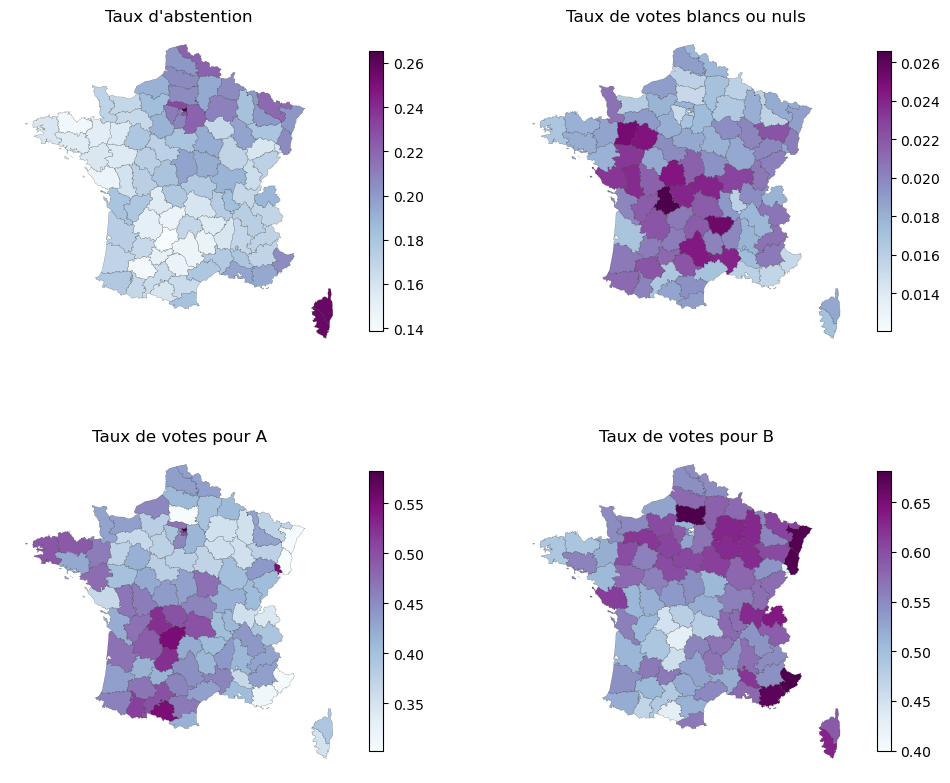

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

info_to_plot = ['t_abs', 't_null', 't_A', 't_B']
labels = ["Taux d'abstention", "Taux de votes blancs ou nuls", "Taux de votes pour A", "Taux de votes pour B"]

for i_row in range(2):
    for i_col in range(2):
        merge_departements.plot(column=info_to_plot[i_col + i_row*2],
                                cmap='BuPu', linewidth=0.1, ax=ax[i_row, i_col], edgecolor='0')
        ax[i_row, i_col].axis('off')
        ax[i_row, i_col].set_title(labels[i_col + i_row*2])
        
        sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=merge_departements[info_to_plot[i_col + i_row*2]].min(), 
                                                                     vmax=merge_departements[info_to_plot[i_col + i_row*2]].max()))
        cbar = fig.colorbar(sm, ax=ax[i_row, i_col], shrink=0.8)  # ajout de la barre de couleurs à l'axe en bas à droite de la figure


Il est judicieux de regarder les deux derniers sur une même échelle pour pouvoir les comparer :

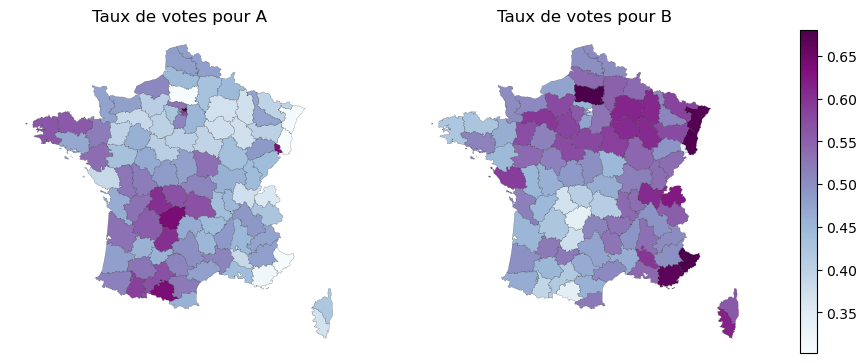

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

info_to_plot = ['t_A', 't_B']
labels = ["Taux de votes pour A", "Taux de votes pour B"]
for i_col in range(2):
    merge_departements.plot(column=info_to_plot[i_col],
                            cmap='BuPu', linewidth=0.1, ax=ax[i_col], edgecolor='0')
    ax[i_col].axis('off')
    ax[i_col].set_title(labels[i_col ])
        
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=merge_departements[info_to_plot[0]].min(), 
                                                             vmax=merge_departements[info_to_plot[1]].max()))
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), shrink=0.7)  # ajout de la barre de couleurs à l'axe en bas à droite de la figure


Premières observations :
- L'abstention est importante à Paris, en Corse et au nord-est; et plutôt basse ailleurs.
- Les votes nuls et les votes blancs sont plus nombreux au centre et à la moitié sud-ouest de la France.
- L'option A a eu de meilleurs résultats autour de Paris et au sud-ouest.
- Les endroits avec un grand taux d'abstention ont davantage voté pour l'option A.
- L'option B a eu de meilleurs résultats à l'est.

### Correlation entre les données

Nous filtrons les données numériques des dataframes. Pour rendre la tâche plus facile, les départements de Corse 2A, 2B seront 96 et 97, et les " Z " seront 98.

In [33]:
def code_change(dep_code):
    if dep_code == '2A':
        return 96
    elif dep_code == '2B':
        return 97
    elif 'Z' in dep_code :
        return 98
    else:
        return int(dep_code)

In [34]:
ref_df['code'] = ref_df['Code du département'].apply(code_change)
merged_df['code'] = merged_df['Code du département'].apply(code_change)

In [35]:
ref_num = ref_df.select_dtypes(include=['number'])
mer_num = merged_df.select_dtypes(include=['number'])

mer_num.head()

Code de la commune  Inscrits  Abstentions  Blancs et nuls  Choix A  \
0                   1       592           84               9      154   
1                   2       215           36               5       66   
2                   4      8205         1698             126     2717   
3                   5      1152          170              18      280   
4                   6       105           17               1       35   

   Choix B     t_abs  Votes    t_null       t_A       t_B  t_hommes  \
0      345  0.141892    508  0.017717  0.303150  0.679134  0.507692   
1      108  0.167442    179  0.027933  0.368715  0.603352  0.529915   
2     3664  0.206947   6507  0.019364  0.417550  0.563086  0.478846   
3      684  0.147569    982  0.018330  0.285132  0.696538  0.504015   
4       52  0.161905     88  0.011364  0.397727  0.590909  0.517857   

   age_moyen  t_emploi   t_cadre  t_ouvriers       med_vie  code  
0  39.300000  0.187097  0.689655    0.620690  22130.000000     1  
1  39.888889  0.042553  2.500000    4.000000  23213.000000     1  
2  37.650003  0.172707  0.365937    1.004225  19554.000000     1  
3  39.041384  0.180451  0.437500    0.958333  22387.619048     1  
4  44.437500  0.181818  0.250000    0.500000  21871.666667     1

Nous enlevons les données absolues qui ne nous serviront pas. On garde les inscrits, parce que cela donne une idée de la population de la commune.

In [36]:
ref_num.drop(['Code de la commune', 'Abstentions', 'Blancs et nuls', 'Votes', 'Choix A', 'Choix B'], axis=1, inplace=True)
mer_num.drop(['Code de la commune', 'Abstentions', 'Blancs et nuls', 'Votes', 'Choix A', 'Choix B'], axis=1, inplace=True)

On fait un heatmap pour le mer_num (toutes les informations) pour savoir quelles données sont correlées :

<AxesSubplot:>

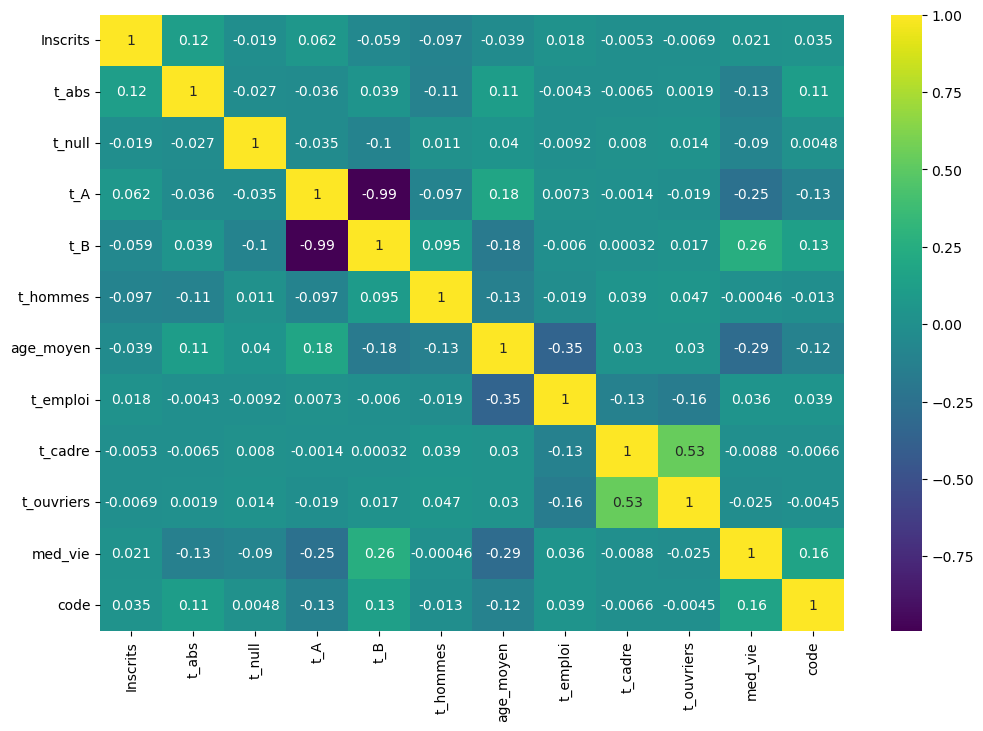

In [37]:
plt.figure(figsize=(12, 8))
correlation_matrix = mer_num.corr()
sns.heatmap(correlation_matrix, cmap='viridis', annot=True)

J'ai essayé de faire un pairplot pour voir l'influence de chaque paramètre sur chaque paramètre, mais la RAM de mon ordinateur n'a pas tenu :

MemoryError: Unable to allocate 112. TiB for an array with shape (15372379559402,) and data type float64

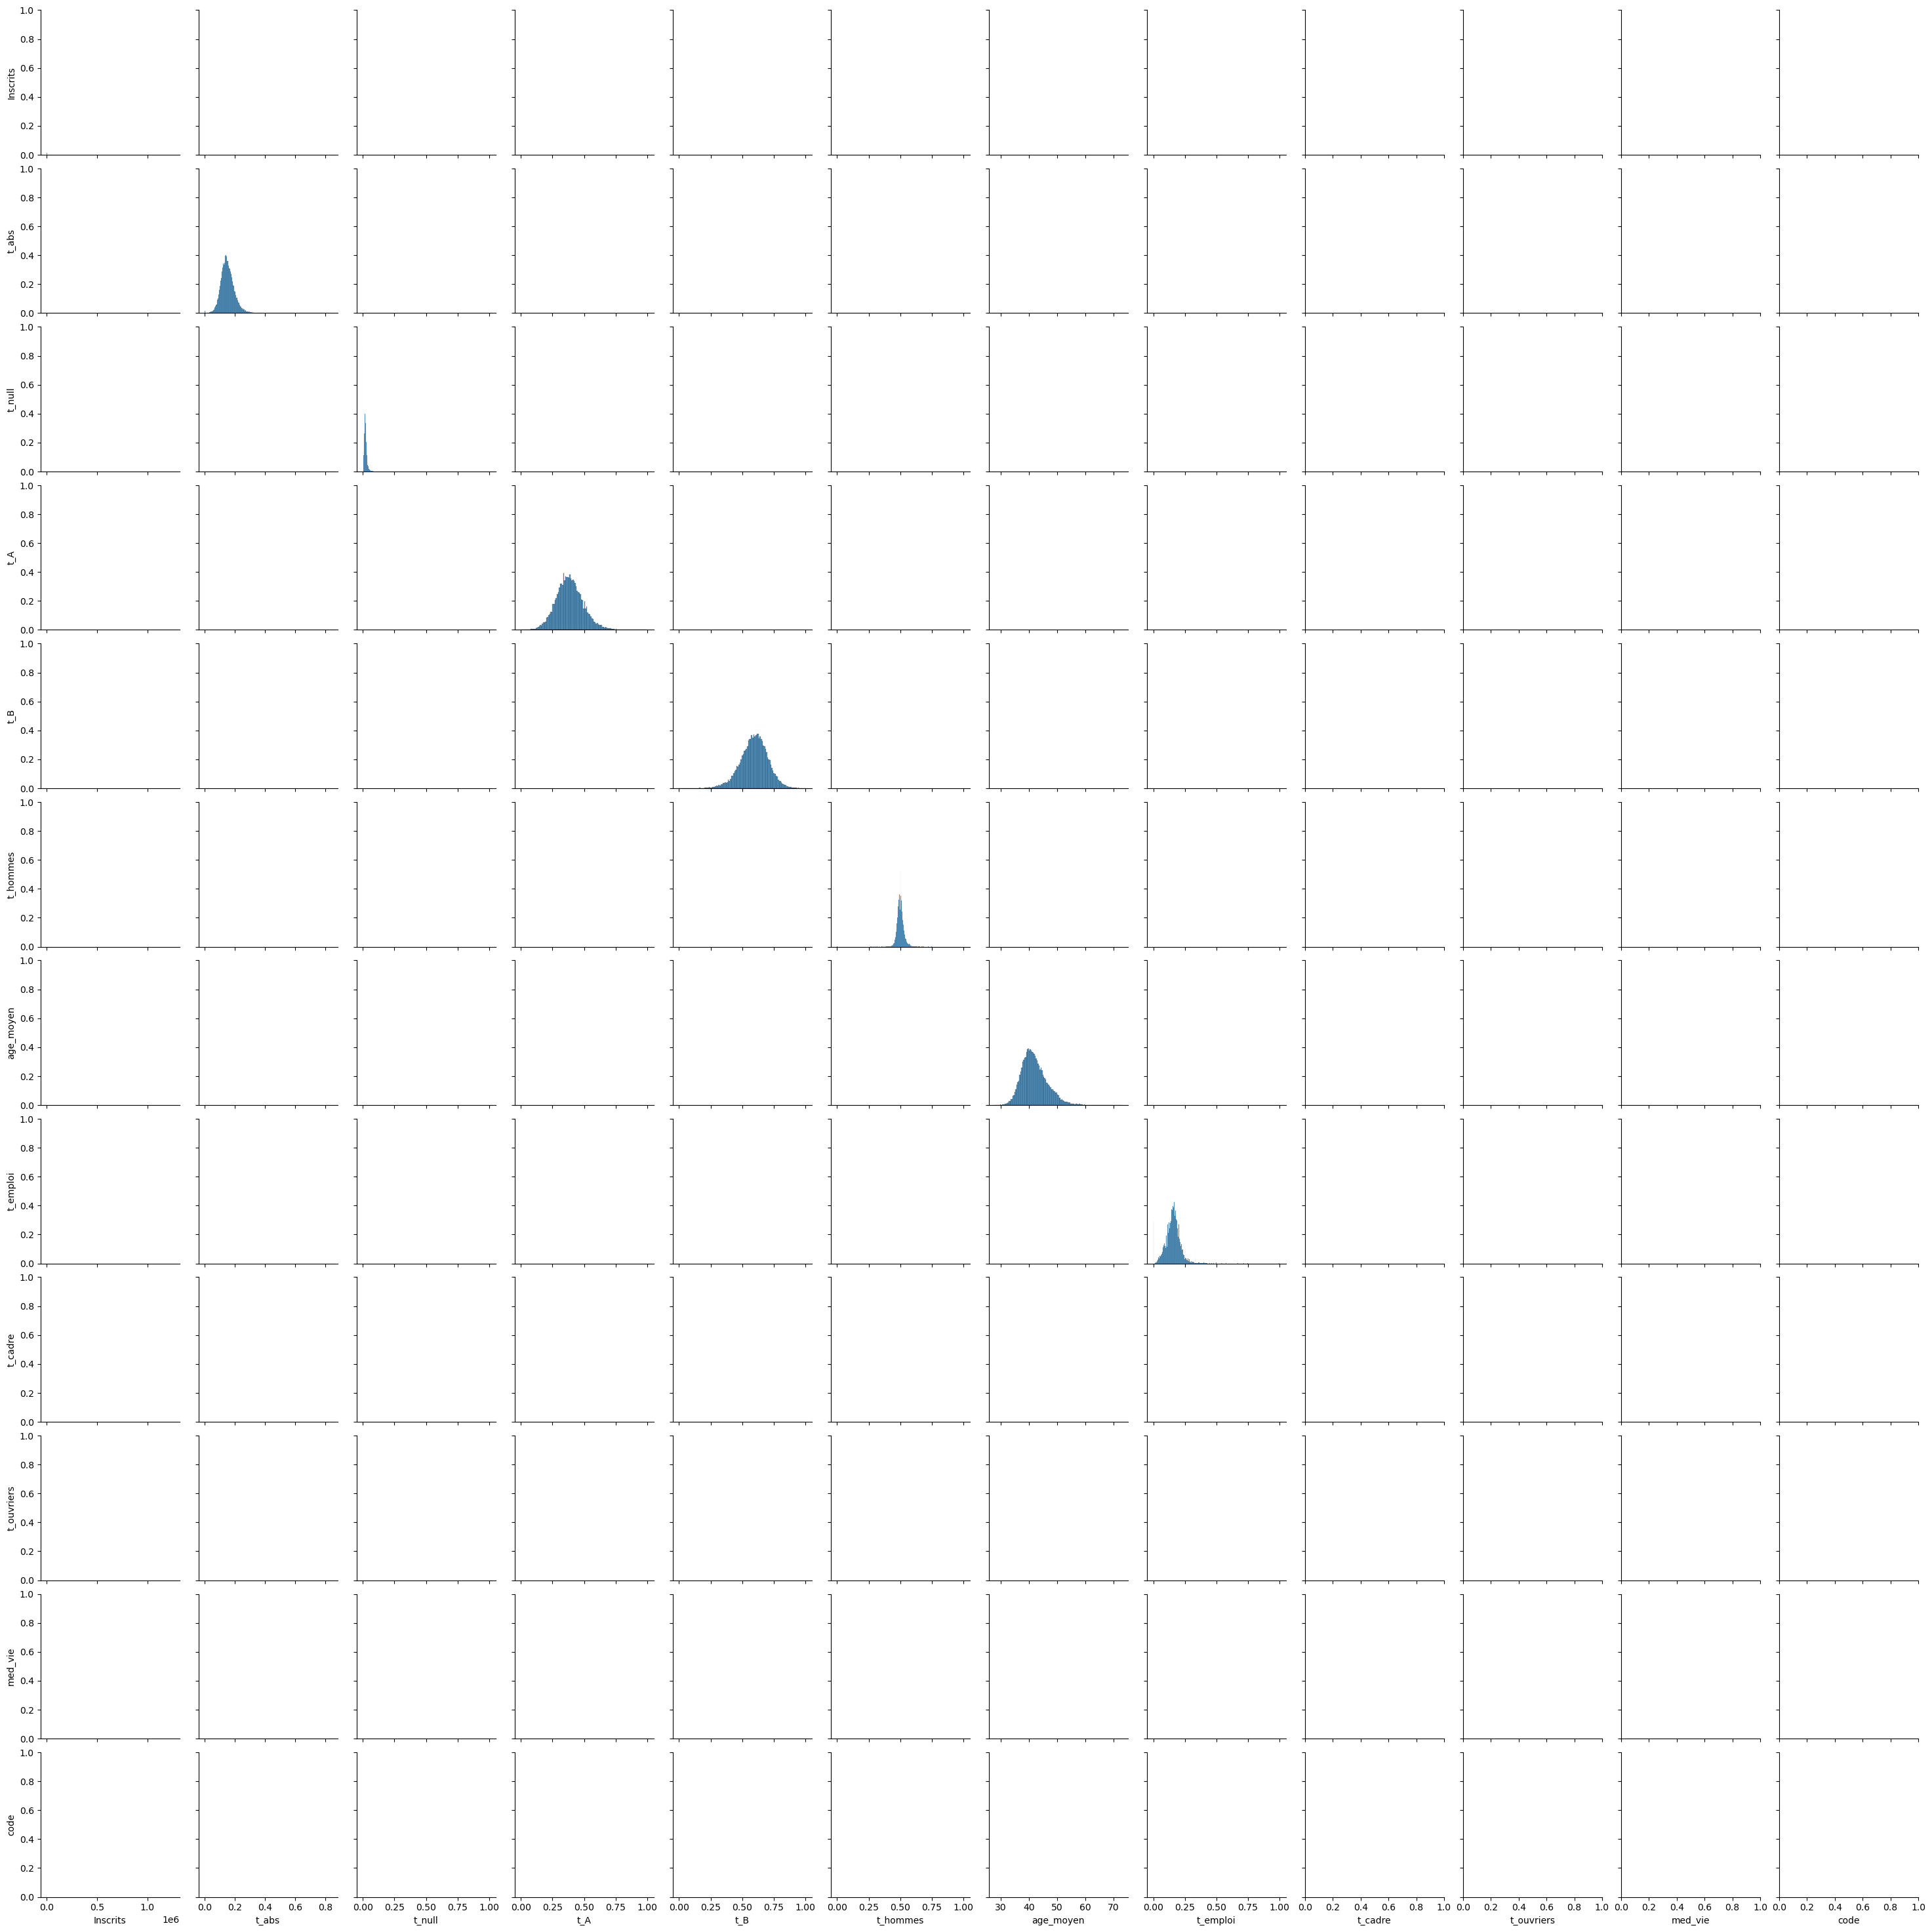

In [100]:
sns.pairplot(mer_num)

On regarde les influences de chaque paramètre de manière individuelle sur les résultats du référendum, et on définit une fonction pour cela. On regardera seulement les paramètres qui donnent plus de 0.01 (ou moins de -0.01) dans la matrice de correlation.

On introduit un "threshold" pour enlever les valeurs les plus basses si besoin - celles-ci rendant l'interprétation plus difficile.

C'est pratique aussi d'avoir la moyenne de A et de B dans des variables (déjà calculées) : 

In [38]:
general_data = [t_abstention, t_null_total, t_votes_A, t_votes_B]

In [79]:
def trace_influence(df, parameter, threshold):
    fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,10))

    info_to_plot = ['t_abs', 't_null', 't_A', 't_B']
    labels = ["Taux d'abstention", "Taux de votes blancs ou nuls", "Taux de votes pour A", "Taux de votes pour B"]
    
    for j, info in enumerate(info_to_plot):
        sns.scatterplot(x=parameter, y=info, data=df[df[parameter] > threshold], size=1, legend=None, ax=axs[j], hue='code')
        axs[j].axhline(general_data[j], color='r')
        
        # pour le text :
        x_text = axs[j].get_xlim()[1]*0.8  
        y_text = axs[j].get_ylim()[1]*0.8  
        
        axs[j].text(x_text, y_text, f"r = {round(correlation_matrix.loc[info][parameter], 3)}")
        if j > 1:
            axs[j].set_ylim(0, 1)
            

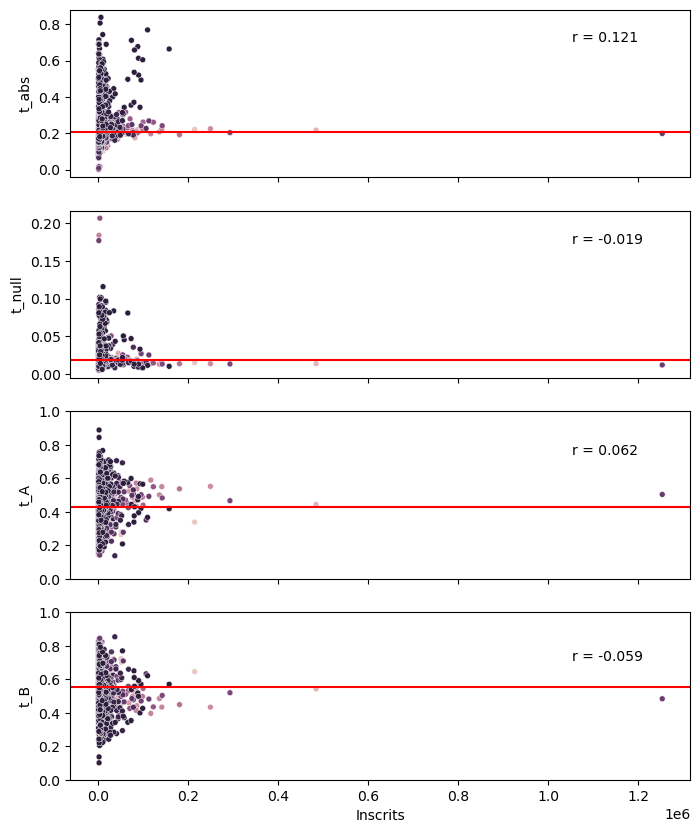

In [56]:
trace_influence(ref_num, 'Inscrits', 1000)

Dans les grandes villes :

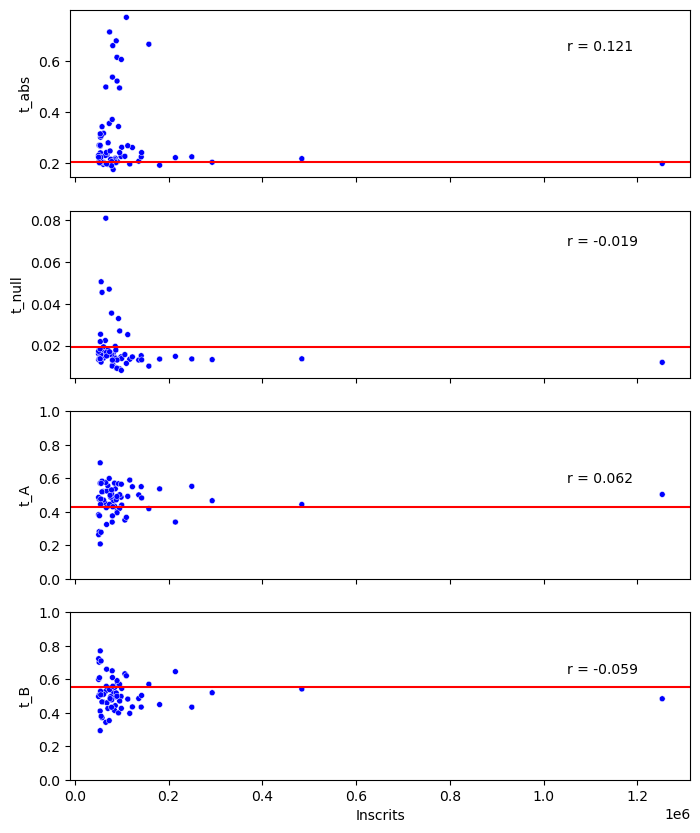

In [38]:
trace_influence(ref_num, 'Inscrits', 50000)

Observations par rapport au nombre d'inscrits :
- Dans les petits villages, l'abstention peut être très variable.
- L'abstention augmente lègèrement avec la population de la commune.
- Dans les très grandes villes, le % de votes nuls et blancs est moins important que dans les villages.
- Le taux du choix A augmente avec la population, tandis que celui du choix B diminue.

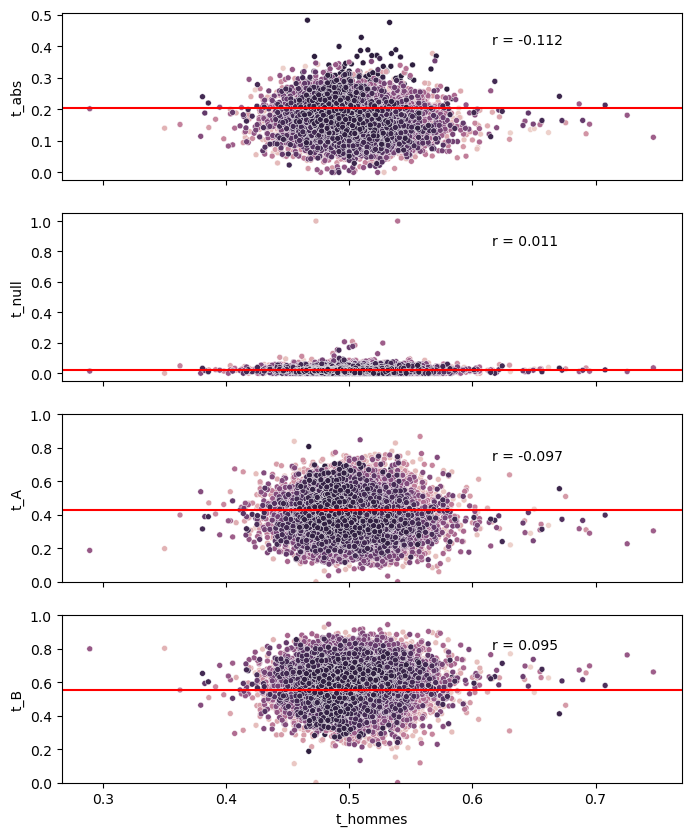

In [57]:
trace_influence(mer_num, 't_hommes', 0)

Observations par rapport au nombre d'hommes dans la commune :
- Là où il y a plus d'hommes, l'abstention est plus basse.
- Les votes nuls et blancs augmentent avec le pourcentage d'hommes.
- Le choix A est plus populaire dans les communes avec plus de femmes.
- Le choix B augmente avec le taux d'hommes.

In [63]:
merged_df['hommes'] = merged_df['Inscrits']*merged_df['t_hommes']

In [64]:
hommes_total = merged_df['hommes'].sum()

In [66]:
def dist_hommes(df, t_low, t_high):
    return sum(df[(df['t_hommes'] > t_low) & (df['t_hommes'] < t_high)]['hommes'])/hommes_total

In [74]:
dist_hommes(merged_df, 0.45, 0.51)

0.9072019806938618

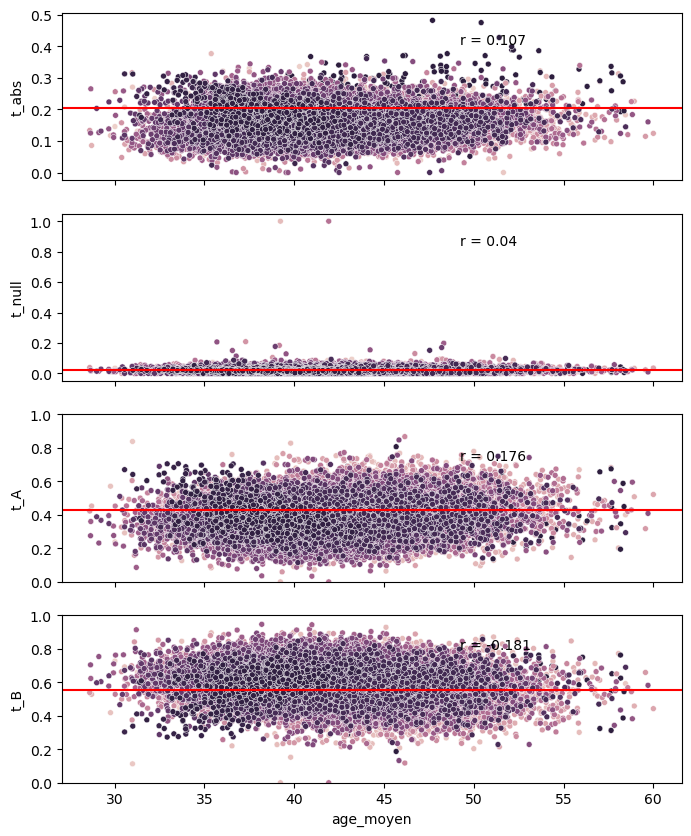

In [75]:
trace_influence(mer_num, 'age_moyen', 0)

Observations par rapport à l'âge moyen :
- L'abstention agumente avec l'age moyen de la commune.
- L'âge moyen fait augmenter légèrement le taux de votes nuls.
- Le choix A augmnete avec l'âge moyen, tandis que le choix B diminue.

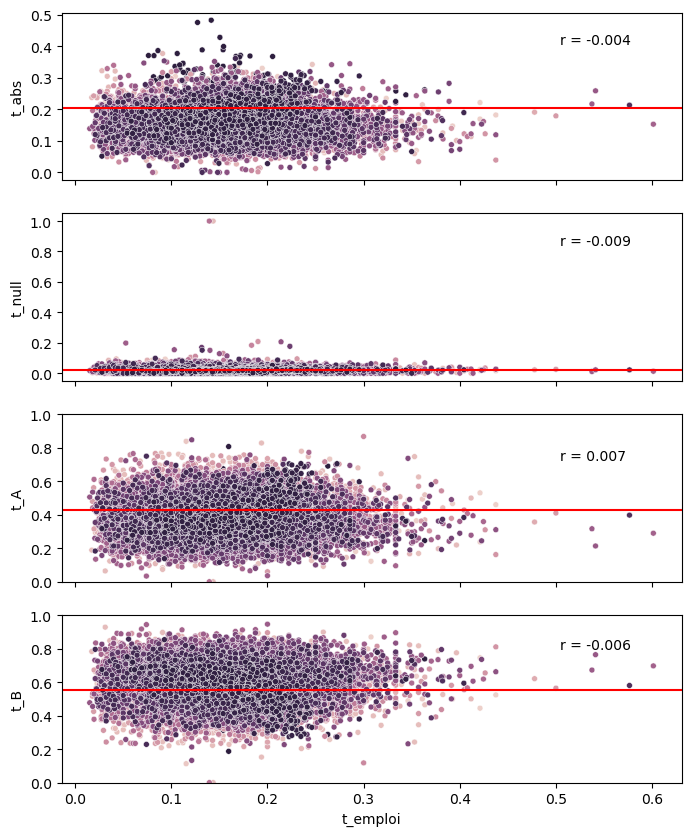

In [76]:
trace_influence(mer_num, 't_emploi', 0)

Le taux d'occupation a une très légère influence sur les résultats du référendum. 
- Il fait augmenter légèrement l'abstention.
- Il fait diminuer légèrement le taux de votes nuls et blancs.

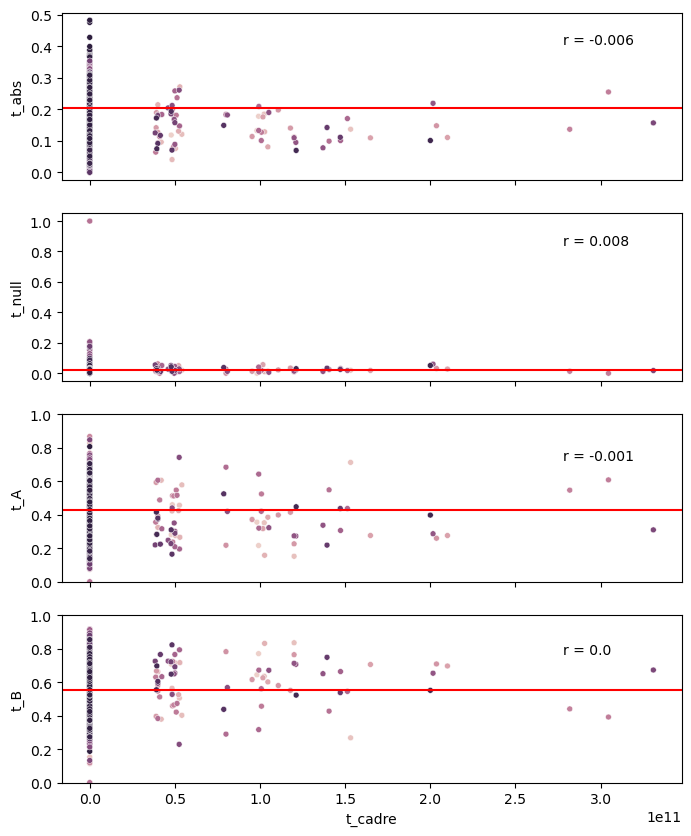

In [81]:
trace_influence(mer_num, 't_cadre', 0)

Le taux de cadres a une très légère influence sur les résultats du référendum. 
- Là où il y a plus de cadres le choix A a davantage été choisi.
- Là où il y a moins de cadres le choix B a été moins populaire.

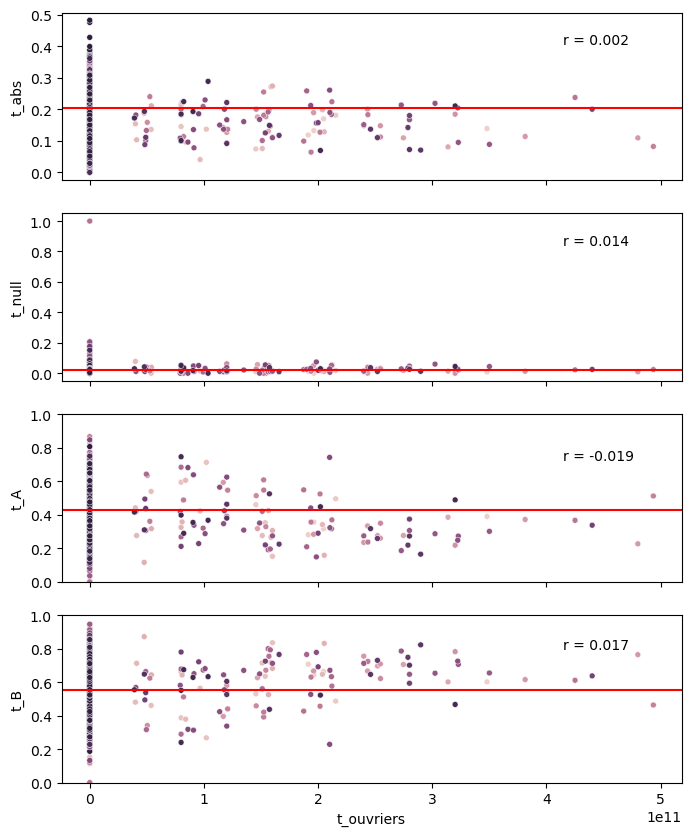

In [82]:
trace_influence(mer_num, 't_ouvriers', 0)

Le taux d'ouvriers a une très légère influence sur les résultats du référendum. 
- Là où il y a moins d'ouvriers le choix A a été davantage choisi.
- Là où il y a plus d'ouvriers le choix B a été moins choisi.

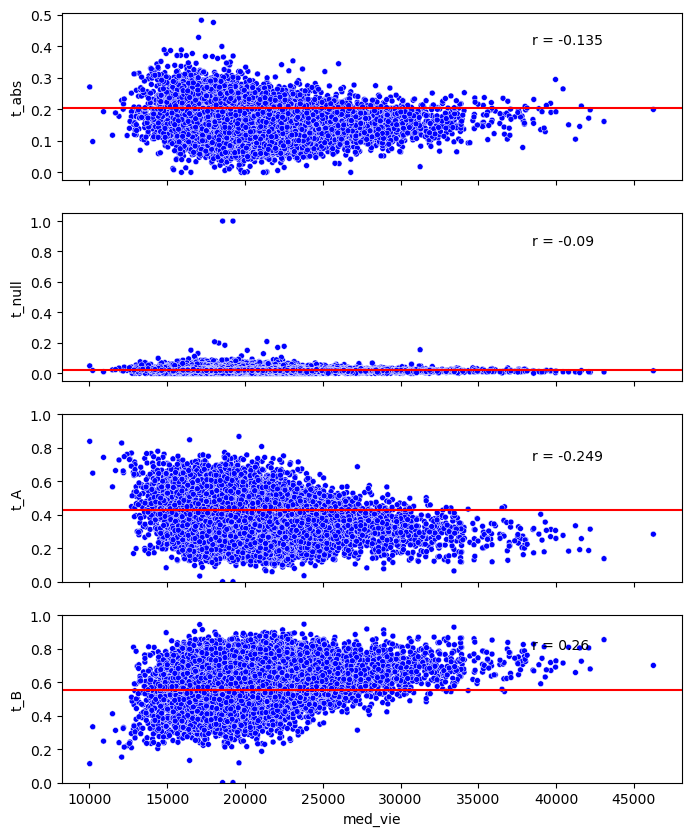

In [212]:
trace_influence(mer_num, 'med_vie', 0)

Observations par rapport au niveau de vie :
- Plus riche une commune est, moins d'abstention et moins de votes blancs et nuls il y a.
- Plus une commune est riche, plus elle a tendance a avoir choisi l'option B - et moins l'option A.

On fait un fit linéaire pour ce dernier example :

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
"""
Pour plus complexe, je ferais :
poly_order = n # ordre du polynome

poly = PolynomialFeatures(poly_order)
X_poly = poly.fit_transform(mer_num['med_vie'].to_numpy().reshape(-1, 1))
model_A = LinearRegression()
model_A.fit(X_poly, mer_num['t_A'])
"""

"\nPour plus complexe, je ferais :\npoly_order = n # ordre du polynome\n\npoly = PolynomialFeatures(poly_order)\nX_poly = poly.fit_transform(mer_num['med_vie'].to_numpy().reshape(-1, 1))\nmodel_A = LinearRegression()\nmodel_A.fit(X_poly, mer_num['t_A'])\n"

In [86]:
model_A = LinearRegression()
model_A.fit(mer_num['med_vie'].to_numpy().reshape(-1, 1), mer_num['t_A'])

LinearRegression()

In [87]:
model_B = LinearRegression()
model_B.fit(mer_num['med_vie'].to_numpy().reshape(-1, 1), mer_num['t_B'])

LinearRegression()

In [88]:
mer_num['fit_A'] = model_A.predict(mer_num['med_vie'].to_numpy().reshape(-1, 1))
mer_num['fit_B'] = model_B.predict(mer_num['med_vie'].to_numpy().reshape(-1, 1))

In [89]:
score_A = model_A.score(mer_num['med_vie'].to_numpy().reshape(-1, 1), mer_num['t_A'])
score_B = model_B.score(mer_num['med_vie'].to_numpy().reshape(-1, 1), mer_num['t_B'])

Text(38449.616666666705, 0.39749999999999996, 'R-squared: 0.0678')

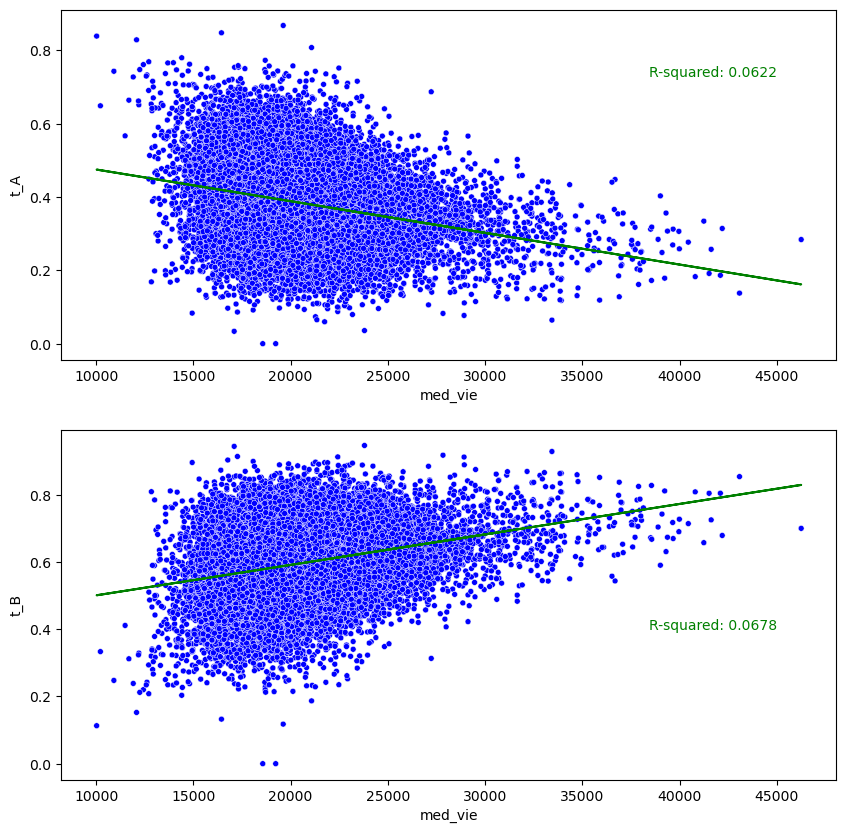

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

sns.scatterplot(x='med_vie', y='t_A', data=mer_num, color='b', size=2, ax=axs[0], legend=None)
axs[0].plot(mer_num['med_vie'], mer_num['fit_A'], color='g')

x_text = axs[0].get_xlim()[1]*0.8  
y_text = axs[0].get_ylim()[1]*0.8  
        
axs[0].text(x_text, y_text, f"R-squared: {round(score_A, 4)}", color='g')

sns.scatterplot(x='med_vie', y='t_B', data=mer_num, color='b', size=2, ax=axs[1], legend=None)
axs[1].plot(mer_num['med_vie'], mer_num['fit_B'], color='g')

x_text = axs[1].get_xlim()[1]*0.8  
y_text = axs[1].get_ylim()[1]*0.4  

axs[1].text(x_text, y_text, f"R-squared: {round(score_B, 4)}", color='g')
# Pour obtenir les valeurs 
#model_A.coef_[0], model_A.intercept_
#model_B.coef_[0], model_B.intercept_

Par curiosité, on tracera avec une hue du code du département :

Text(38449.616666666705, 0.39749999999999996, 'R-squared: 0.0678')

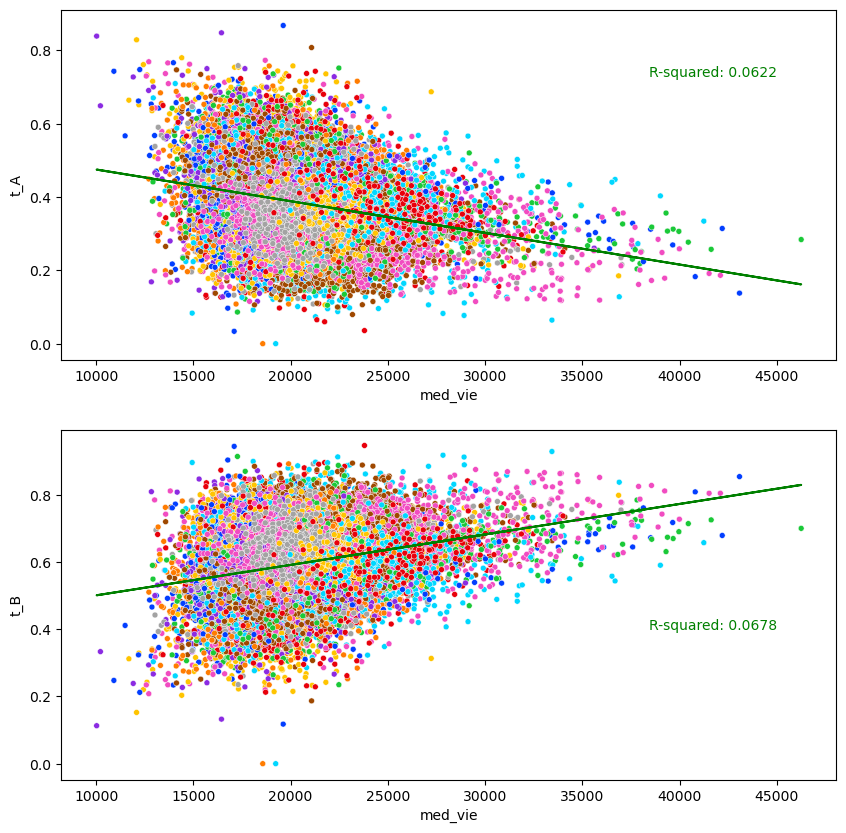

In [270]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

sns.scatterplot(x='med_vie', y='t_A', data=mer_num, hue='code', palette='bright', size=2, ax=axs[0], legend=None)
axs[0].plot(mer_num['med_vie'], mer_num['fit_A'], color='g')

x_text = axs[0].get_xlim()[1]*0.8  
y_text = axs[0].get_ylim()[1]*0.8  
        
axs[0].text(x_text, y_text, f"R-squared: {round(score_A, 4)}", color='g')

sns.scatterplot(x='med_vie', y='t_B', data=mer_num, hue='code', palette='bright', size=2, ax=axs[1], legend=None)
axs[1].plot(mer_num['med_vie'], mer_num['fit_B'], color='g')

x_text = axs[1].get_xlim()[1]*0.8  
y_text = axs[1].get_ylim()[1]*0.4  

axs[1].text(x_text, y_text, f"R-squared: {round(score_B, 4)}", color='g')
# Pour obtenir les valeurs 
#model_A.coef_[0], model_A.intercept_
#model_B.coef_[0], model_B.intercept_



On pourrait sûrement combiner ce graphe avec les analyses de la carte pour relier les données.

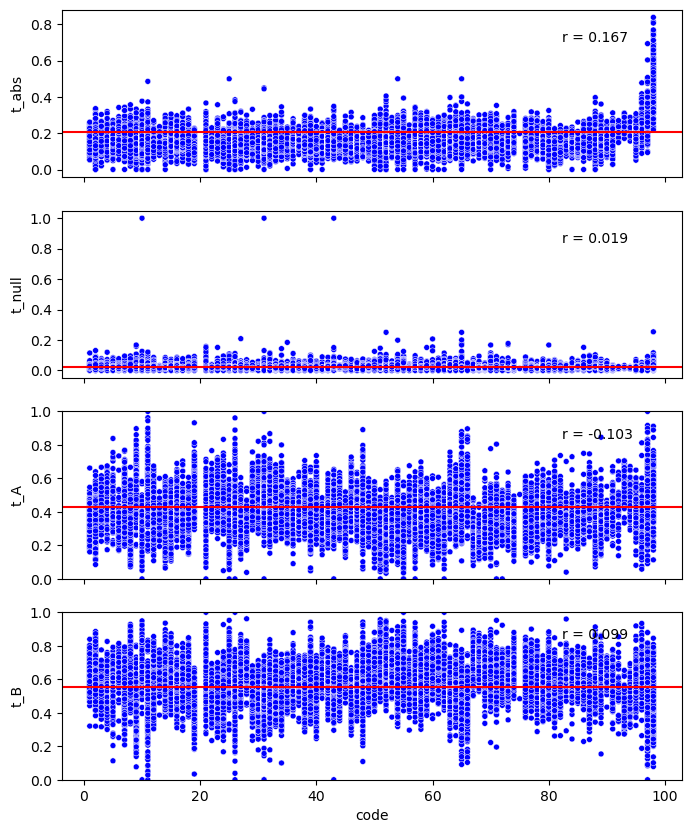

In [211]:
trace_influence(mer_num, 'code', 0)

Cette variable est plus difficile à interpréter.

___________________________________________________________

## Conclusions

On essaie d'extraire des conclusions des données. Par rapport aux corrélations, nous utiliserons les critères suivants :

- Forte corrélation (> 0.2) : + + + / - - -
- Moyenne corrélation (> 0.1) : + + / - -
- Faible corrélation (> 0.01) : + / -
_________________________________

<style>
  table {
    font-size: 30px;
  }
</style>


|          | Abstention | Nuls et blancs | Choix A | Choix B |
|----------|----------|----------|----------|----------|
| Geographique  | Importante à Paris, <br> Corse et nord-est | Plus au centre <br>et moitié sud-ouest | Plus à Paris <br> et sud-ouest | Plus à l'est
| Population  | + +  |   |  +  | -  |
| % Hommes  | -  | + |  -  | +  |
|Âge moyen  | + +  | + |  + +  | - -  |
| % Emploi  | -  | - |     |    |
| % Cadres  |    | - |  +  |  - |
| % Ouvriers  |    |   |  -  | +  |
| Niveau de vie  | - -  | - |  - - -  | + + +  |



______________________
En conclusion, il paraît que les paramètres qui ont plus de relation avec les résultats du réferenfum (au-délà des observations géographiques) sont la population de la commune, l'âge moyen et le niveau de vie moyen de la commune.